In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.etoile_ventes_avis import graphe_etoile_ventes_avis
import seaborn as sns
DATA_PATH = "../donnees/ecommerce/"

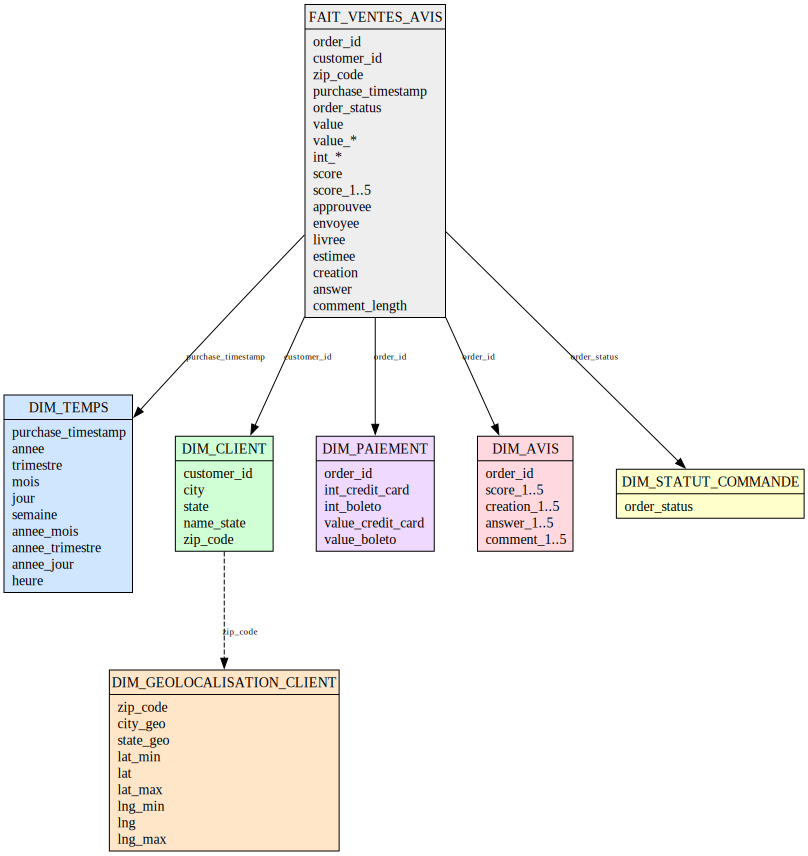

In [66]:
dot_ventes = graphe_etoile_ventes_avis()
dot_ventes

In [67]:
orders    = pd.read_parquet(DATA_PATH + "orders.parquet")
payments  = pd.read_parquet(DATA_PATH + "payments.parquet")
reviews   = pd.read_parquet(DATA_PATH + "reviews.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")
geo       = pd.read_parquet(DATA_PATH + "geolocation.parquet")

In [68]:
# == Diagnostic des scores dans 'reviews' ==

nb_total = len(reviews)
nb_anormaux = (reviews["score"] > 5).sum()

print(f"Lignes totales : {nb_total}")
print(f"Lignes avec score > 5 : {nb_anormaux}")

print("Valeurs distinctes détectées :")
print(sorted(reviews["score"].dropna().unique()))
print()

Lignes totales : 98673
Lignes avec score > 5 : 460
Valeurs distinctes détectées :
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(13), np.int64(15)]



In [69]:
# === CLEAN DES SCORES D'AVIS ===
print("== Nettoyage des scores dans 'reviews' ==")

# Scores autorisés : 1 à 5 ou NaN
mask_scores_valides = reviews["score"].isna() | (
    (reviews["score"] >= 1) & (reviews["score"] <= 5)
)

nb_total = len(reviews)
nb_valid = mask_scores_valides.sum()
nb_drop  = nb_total - nb_valid

print(f"Lignes totales : {nb_total}")
print(f"Lignes conservées (score 1 à 5 ou NaN) : {nb_valid}")
print(f"Lignes supprimées (score > 5) : {nb_drop}")

# On garde uniquement les lignes valides
reviews = reviews[mask_scores_valides].copy()

print("Valeurs distinctes après nettoyage :")
print(sorted(reviews["score"].dropna().unique()))
print()

== Nettoyage des scores dans 'reviews' ==
Lignes totales : 98673
Lignes conservées (score 1 à 5 ou NaN) : 98213
Lignes supprimées (score > 5) : 460
Valeurs distinctes après nettoyage :
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]



In [70]:
print("Shapes brutes apres cleans :")
print("orders   :", orders.shape)
print("payments :", payments.shape)
print("reviews  :", reviews.shape)
print("customers:", customers.shape)
print("geo      :", geo.shape)

Shapes brutes apres cleans :
orders   : (99441, 23)
payments : (103886, 5)
reviews  : (98213, 25)
customers: (99441, 6)
geo      : (19015, 9)


In [71]:
# 1) Préparation des paiements (pivot par type de paiement)
pay = payments.rename(columns=lambda c: c.replace("payment_", ""))

pay_pivot = (
    pay
    .pivot_table(
        index="order_id",
        columns="type",
        values=["installments", "value"],
        aggfunc={"installments": "max", "value": "sum"}
    )
)

pay_pivot.columns = [f"{k}_{t}" for (k, t) in pay_pivot.columns]
pay_pivot = pay_pivot.rename(columns=lambda c: c.replace("installments_", "int_"))

value_cols = [c for c in pay_pivot.columns if c.startswith("value_")]
pay_pivot["value"] = pay_pivot[value_cols].sum(axis=1)

pay_pivot = pay_pivot.reset_index()


# 2) Préparation des avis (colonnes score, délais, longueur commentaire)
rev = reviews.copy()

base_cols = ["order_id"]
for c in ["score", "creation", "answer", "comment"]:
    if c in rev.columns:
        base_cols.append(c)

detail_cols = [
    c for c in rev.columns
    if (
        c.startswith("score_")
        or c.startswith("creation_")
        or c.startswith("answer_")
        or (c.startswith("comment_") and c != "comment")
    )
]

cols_reviews = list(dict.fromkeys(base_cols + detail_cols))

reviews_dim = rev[cols_reviews].copy()
if "comment" in reviews_dim.columns:
    reviews_dim = reviews_dim.rename(columns={"comment": "comment_length"})


# 3) Préparation des infos client (clé client + zip_code) + Correction des durées dans orders (en mémoire)
cust_fact = customers[["customer_id", "zip_code"]].copy()

orders = orders.copy()

delta_approuvee = orders["approved_at"] - orders["purchase_timestamp"]
delta_envoyee   = orders["delivered_carrier"] - orders["purchase_timestamp"]
delta_livree    = orders["delivered_customer"] - orders["purchase_timestamp"]
delta_estimee   = orders["estimated_delivery"] - orders["purchase_timestamp"]

orders["approuvee"] = delta_approuvee.dt.total_seconds() / 3600
orders["envoyee"]   = delta_envoyee.dt.total_seconds() / 3600
orders["livree"]    = delta_livree.dt.total_seconds() / 3600
orders["estimee"]   = delta_estimee.dt.total_seconds() / 3600


# 4) Construction de la table de faits F_VENTES_AVIS (jointures)
fact_orders_cols = [
    "order_id",
    "customer_id",
    "purchase_timestamp",
    "order_status",
    "approuvee",
    "envoyee",
    "livree",
    "estimee",
]
fact_orders_cols = [c for c in fact_orders_cols if c in orders.columns]

fact_orders = orders[fact_orders_cols].copy()

F_VENTES_AVIS = (
    fact_orders
    .merge(cust_fact,   on="customer_id", how="left")
    .merge(pay_pivot,   on="order_id",   how="left")
    .merge(reviews_dim, on="order_id",   how="left")
)

cols_schema = [
    "order_id",
    "customer_id",
    "zip_code",
    "purchase_timestamp",
    "order_status",
    "value",
    "approuvee",
    "envoyee",
    "livree",
    "estimee",
    "score",
    "creation",
    "answer",
    "comment_length",
]

extra_cols = [
    c for c in F_VENTES_AVIS.columns
    if c.startswith("value_")
    or c.startswith("int_")
    or c.startswith("score_")
    or c.startswith("creation_")
    or c.startswith("answer_")
    or (c.startswith("comment_") and c != "comment_length")
]

final_cols = [c for c in cols_schema + extra_cols if c in F_VENTES_AVIS.columns]
F_VENTES_AVIS = F_VENTES_AVIS[final_cols]


# 5) Contrôle rapide du résultat
print("F_VENTES_AVIS shape :", F_VENTES_AVIS.shape)
print("Colonnes (", len(F_VENTES_AVIS.columns), "):")
print(list(F_VENTES_AVIS.columns))

display(F_VENTES_AVIS.head(5))


# 6) Sauvegarde en Parquet pour les autres analyses
OUTPUT_PATH = "f_ventes_avis.parquet"

F_VENTES_AVIS.to_parquet(OUTPUT_PATH, index=False)
print(f"F_VENTES_AVIS sauvegardé dans : {OUTPUT_PATH}")


F_VENTES_AVIS shape : (99441, 43)
Colonnes ( 43 ):
['order_id', 'customer_id', 'zip_code', 'purchase_timestamp', 'value', 'approuvee', 'envoyee', 'livree', 'estimee', 'score', 'creation', 'answer', 'comment_length', 'int_boleto', 'int_credit_card', 'int_debit_card', 'int_not_defined', 'int_voucher', 'value_boleto', 'value_credit_card', 'value_debit_card', 'value_not_defined', 'value_voucher', 'answer_1', 'answer_2', 'answer_3', 'answer_4', 'answer_5', 'comment_1', 'comment_2', 'comment_3', 'comment_4', 'comment_5', 'creation_1', 'creation_2', 'creation_3', 'creation_4', 'creation_5', 'score_1', 'score_2', 'score_3', 'score_4', 'score_5']


,order_id,customer_id,zip_code,purchase_timestamp,value,approuvee,envoyee,livree,estimee,score,...,creation_1,creation_2,creation_3,creation_4,creation_5,score_1,score_2,score_3,score_4,score_5
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3149,2017-10-02 10:56:33,38.71,0.178333,56.974167,202.477778,373.057500,4.0,...,0.0,0.0,0.0,205.0,0.0,0.0,0.0,0.0,1.0,0.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,47813,2018-07-24 20:41:37,141.46,30.713889,41.823056,330.768889,459.306389,4.0,...,0.0,0.0,0.0,339.0,0.0,0.0,0.0,0.0,1.0,0.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,75265,2018-08-08 08:38:49,179.12,0.276111,5.186389,225.461111,639.353056,5.0,...,0.0,0.0,0.0,0.0,231.0,0.0,0.0,0.0,0.0,1.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,59296,2017-11-18 19:28:06,72.20,0.298056,90.198056,317.010000,628.531667,5.0,...,0.0,0.0,0.0,0.0,340.0,0.0,0.0,0.0,0.0,1.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,9195,2018-02-13 21:18:39,28.62,1.030556,22.465278,68.973056,290.689167,5.0,...,0.0,0.0,0.0,0.0,74.0,0.0,0.0,0.0,0.0,1.0


F_VENTES_AVIS sauvegardé dans : f_ventes_avis.parquet


In [72]:
# Analyse 1 : Performance commerciale & saisonnalité vs satisfaction
# Dans cette première analyse, je veux comprendre la dynamique globale du business :
# comment évoluent les ventes dans le temps (année, trimestre, mois) et comment cela
# se connecte à la satisfaction client (score moyen des avis). C’est la vue d’ensemble
# indispensable avant d’entrer dans le détail opérationnel : je pars du CA total et du
# volume de commandes, puis je descends dans les hiérarchies de temps et de géographie
# pour identifier les saisons fortes, les périodes faibles et les zones clés.

In [73]:
# Préparation
fva = F_VENTES_AVIS.copy()
fva["year"] = fva["purchase_timestamp"].dt.year
fva["month"] = fva["purchase_timestamp"].dt.month
fva["year_month"] = fva["purchase_timestamp"].dt.to_period("M").dt.to_timestamp()


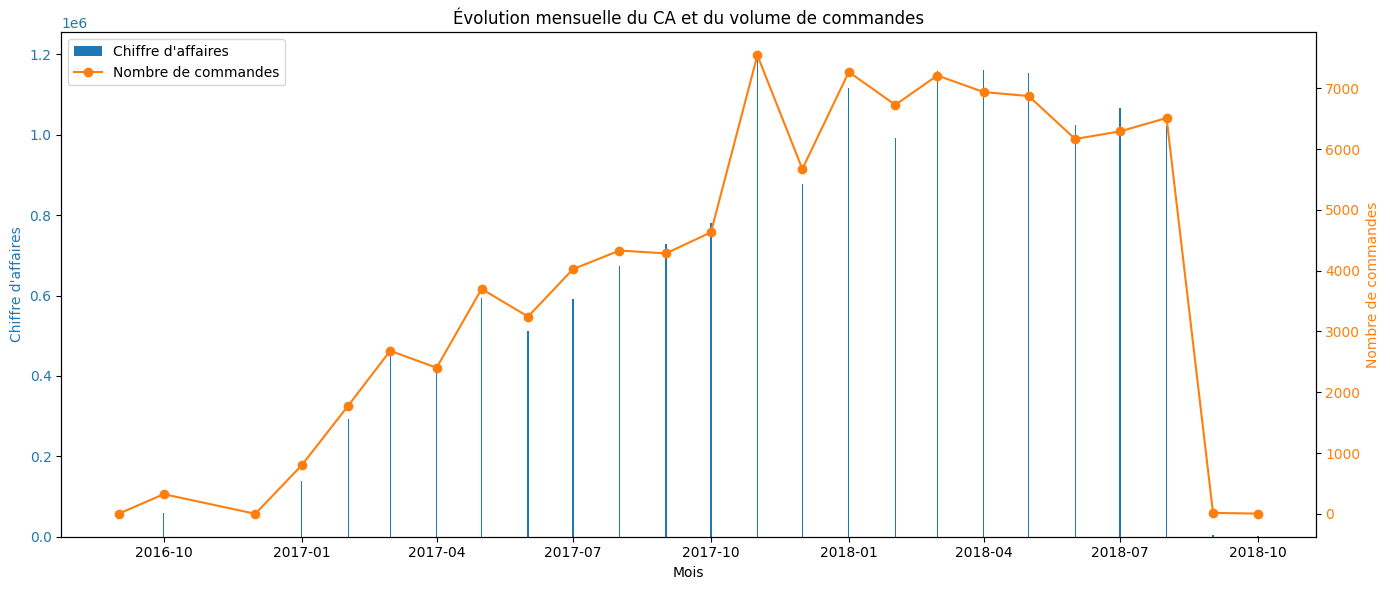

In [85]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# CA : barres en bleu (axe de gauche)
ax1.bar(monthly["year_month"], monthly["revenue"], color="C0", label="Chiffre d'affaires")
ax1.set_xlabel("Mois")
ax1.set_ylabel("Chiffre d'affaires", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")

# Volume : courbe en orange (axe de droite)
ax2 = ax1.twinx()
ax2.plot(monthly["year_month"], monthly["orders_count"],
         marker="o", color="C1", label="Nombre de commandes")
ax2.set_ylabel("Nombre de commandes", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")

plt.title("Évolution mensuelle du CA et du volume de commandes")

# Légende combinée
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()


In [75]:
# Le chiffre d’affaires suit de très près la dynamique du nombre de commandes,
# ce qui montre que la croissance vient surtout de l’augmentation des volumes
# plutôt que d’un panier moyen en forte variation.
# On observe une montée rapide jusqu’à fin 2017, avec un pic net en novembre,
# très probablement lié au Black Friday et aux achats de fin d’année anticipés.
# L’activité reste ensuite élevée en 2018, tandis que la satisfaction demeure
# globalement stable. La baisse après août 2018 vient simplement de la fin du dataset.


== 2) Score moyen par mois (>= 100 commandes) ==
  year_month  avg_score  orders_count
1 2016-10-01   3.552050           324
3 2017-01-01   4.056122           800
4 2017-02-01   4.014205          1780
5 2017-03-01   4.075878          2682
6 2017-04-01   4.047859          2404


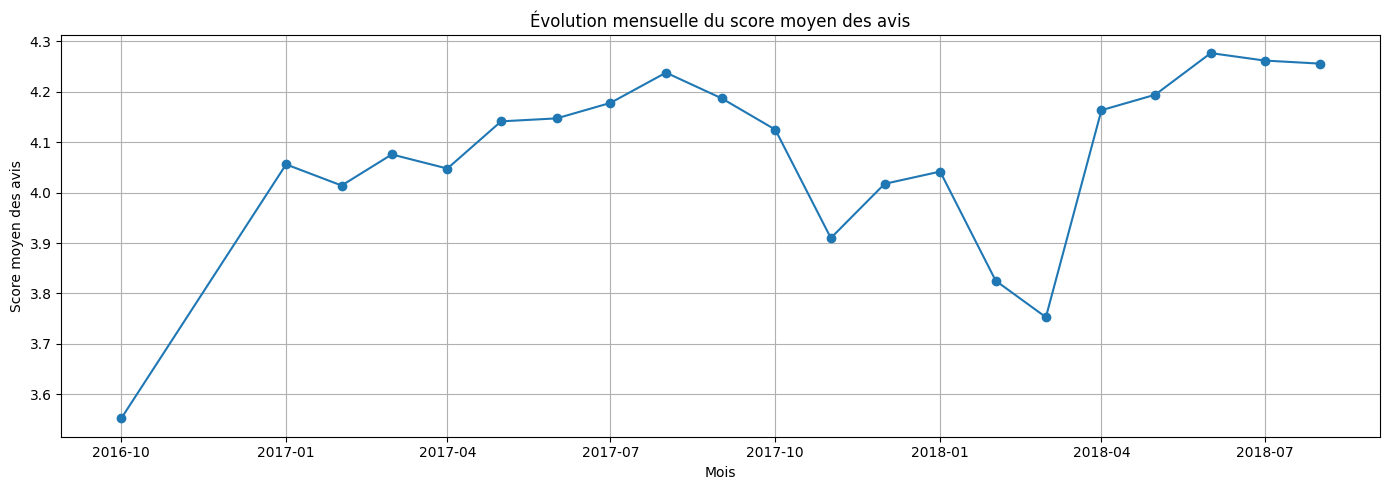

In [78]:
# 2) Évolution mensuelle du score moyen des avis

monthly_score = (
    fva
    .groupby("year_month", as_index=False)
    .agg(
        avg_score=("score", "mean"),
        orders_count=("order_id", "nunique")
    )
)

# On se limite aux mois avec un volume suffisant
ms_robust = monthly_score[monthly_score["orders_count"] >= 100].copy()

print("== 2) Score moyen par mois (>= 100 commandes) ==")
print(ms_robust[["year_month", "avg_score", "orders_count"]].head())

plt.figure(figsize=(14, 5))
plt.plot(ms_robust["year_month"], ms_robust["avg_score"], marker="o")
plt.xlabel("Mois")
plt.ylabel("Score moyen des avis")
plt.title("Évolution mensuelle du score moyen des avis")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Le score moyen progresse nettement jusqu’à mi-2017, puis connaît deux baisses distinctes.
# La première, en novembre 2017, intervient exactement au moment du pic absolu
# d’activité : volume et CA au plus haut. La surcharge logistique est donc l’explication la plus probable.
# La seconde baisse, début 2018, apparaît dans un contexte différent : le volume
# reste élevé mais le CA recule, ce qui indique un panier moyen plus faible.
# Cette combinaison (beaucoup de commandes, souvent plus petites) s’accompagne
# d’une satisfaction plus basse, possiblement liée à un mix produit plus sensible
# aux réclamations ou à une performance opérationnelle moins stable.


== 3) Pivot CA (année x mois) ==
month          1          2           3           4           5           6   \
year                                                                           
2016          NaN        NaN         NaN         NaN         NaN         NaN   
2017    138488.04  291908.01   449863.60   417788.03   592918.82   511276.38   
2018   1115004.18  992463.34  1159652.12  1160785.48  1153982.15  1023880.50   

month          7           8          9          10         11         12  
year                                                                       
2016          NaN         NaN     252.24   59090.48        NaN      19.62  
2017    592382.92   674396.32  727762.45  779677.88  1194882.8  878401.48  
2018   1066540.75  1022425.32    4439.54     589.67        NaN        NaN  

== Pivot score moyen (année x mois) ==
month        1         2         3         4         5         6         7   \
year                                                               

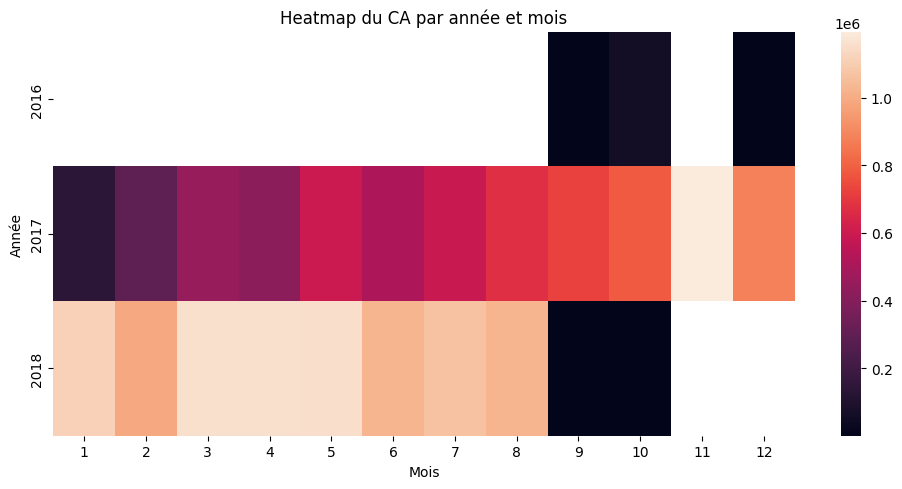

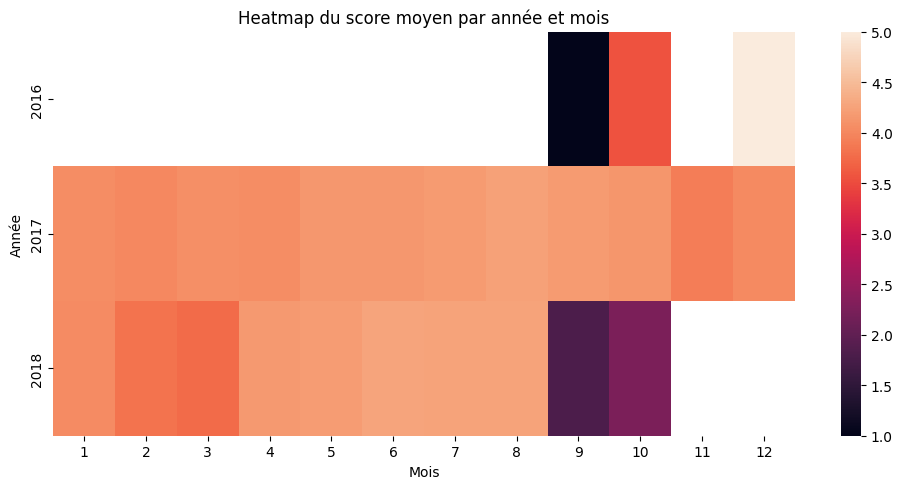

In [86]:
# 3) Heatmaps année x mois : chiffre d'affaires et score moyen

# Préparation
monthly2 = (
    fva
    .groupby(["year", "month"], as_index=False)
    .agg(
        orders_count=("order_id", "nunique"),
        revenue=("value", "sum"),
        avg_score=("score", "mean")
    )
)


pivot_rev = monthly2.pivot(index="year", columns="month", values="revenue")
pivot_score = monthly2.pivot(index="year", columns="month", values="avg_score")

# Affichage
print("== 3) Pivot CA (année x mois) ==")
print(pivot_rev)

print("\n== Pivot score moyen (année x mois) ==")
print(pivot_score)

plt.figure(figsize=(10, 5))
sns.heatmap(pivot_rev, annot=False)
plt.title("Heatmap du CA par année et mois")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.heatmap(pivot_score, annot=False)
plt.title("Heatmap du score moyen par année et mois")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()


In [ ]:
# Cette double heatmap ne fait que confirmer les résultats des deux analyses précédentes :
# on retrouve la montée continue du CA jusqu’au pic de novembre 2017, puis la stabilisation
# et la fin brutale des données en 2018. Le score moyen suit la même logique que précédemment :
# il reste stable sur l’année mais chute lors des pics d’activité, en particulier autour
# du Black Friday. Ce graphe apporte donc une lecture synthétique temps × intensité qui
# renforce et valide les observations déjà établies sur la saisonnalité et la satisfaction.

== 4) Distribution des scores d'avis ==
   score  orders_count     revenue
0    1.0         11286  2211295.76
1    2.0          3139   541828.52
2    3.0          8085  1227317.14
3    4.0         18964  2939446.92
4    5.0         56739  8880388.22

Score moyen global (toutes commandes) :
4.086729862645474


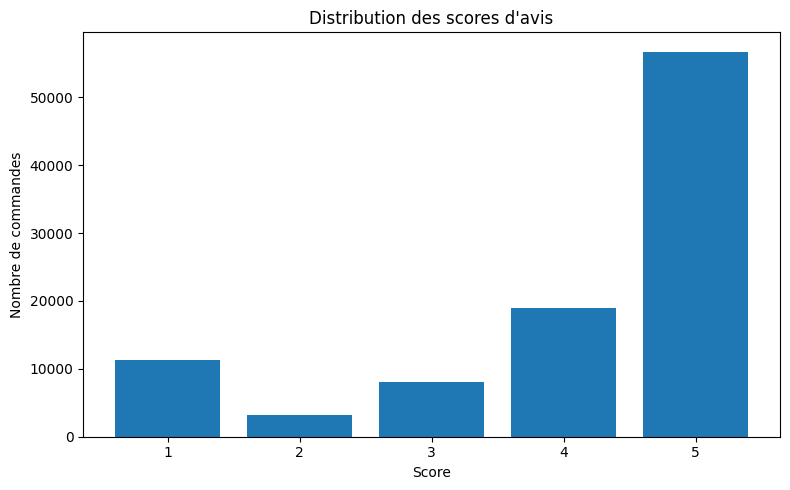

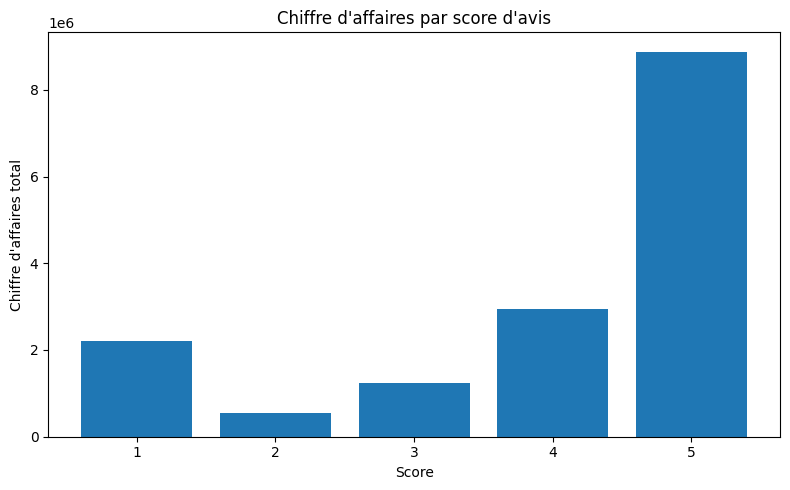

In [50]:
# 4) Distribution globale des scores d'avis

# Préparation
score_dist = (
    fva
    .groupby("score", as_index=False)
    .agg(
        orders_count=("order_id", "nunique"),
        revenue=("value", "sum")
    )
)

# Affichage
print("== 4) Distribution des scores d'avis ==")
print(score_dist)

print("\nScore moyen global (toutes commandes) :")
print(fva["score"].mean())

plt.figure(figsize=(8, 5))
plt.bar(score_dist["score"], score_dist["orders_count"])
plt.xlabel("Score")
plt.ylabel("Nombre de commandes")
plt.title("Distribution des scores d'avis")
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(score_dist["score"], score_dist["revenue"])
plt.xlabel("Score")
plt.ylabel("Chiffre d'affaires total")
plt.title("Chiffre d'affaires par score d'avis")
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()


In [ ]:
# Un graphique cette fois qualitatif centré sur la satisfaction client.
# La distribution est très asymétrique : la note 5 domine, mais la note 1 reste
# la seconde plus fréquente, ce qui reflète un comportement typique du e-commerce :
# les clients expriment surtout une forte satisfaction ou une forte insatisfaction.
# Les notes intermédiaires (2–4) sont moins représentées, souvent liées à une
# expérience correcte mais avec une légère déception (retard, produit différent, etc.).
# Les commandes bien notées concentrent l’essentiel du CA, tandis que les notes
# basses concernent surtout des achats de plus faible valeur.
# La satisfaction globale est élevée mais polarisée, révélant une sensibilité sur
# les cas où l’expérience dévie de la promesse attendue.


== 5) Score moyen par classe de délai de livraison ==
  delivery_bucket  orders_count     revenue  avg_score
0            <=1j            13     2188.90   4.230769
1            1-3j          4740   574301.84   4.483220
2            3-7j         21293  2997473.46   4.404271
3           7-14j         40215  6448216.88   4.312340
4            >14j         30215  5399650.35   3.718845


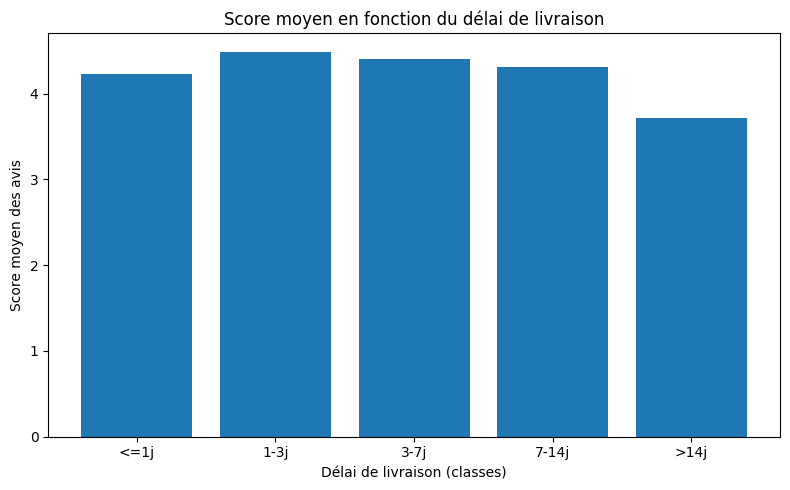

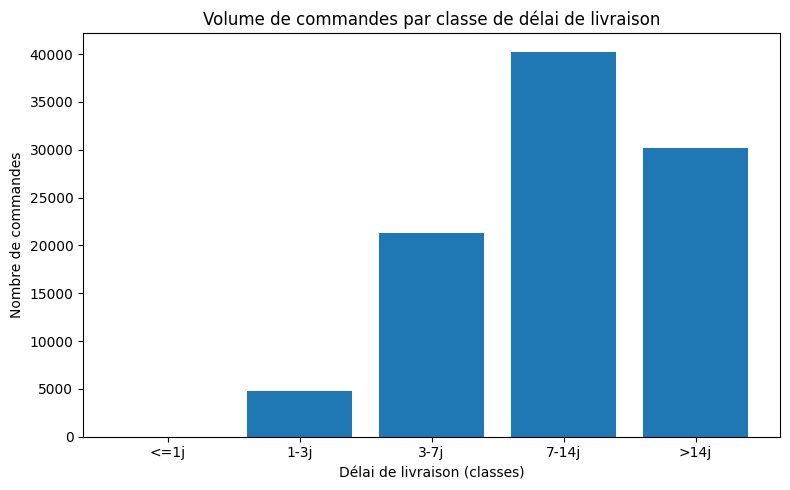

In [51]:
# 5) Score moyen en fonction du délai de livraison (classes de délai)

# Préparation
tmp = fva.copy()
tmp = tmp[tmp["livree"].notna() & (tmp["livree"] > 0)]

bins = [0, 24, 72, 168, 336, np.inf]
labels = ["<=1j", "1-3j", "3-7j", "7-14j", ">14j"]

tmp["delivery_bucket"] = pd.cut(
    tmp["livree"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

delivery_score = (
    tmp
    .groupby("delivery_bucket", as_index=False, observed=False)
    .agg(
        orders_count=("order_id", "nunique"),
        revenue=("value", "sum"),
        avg_score=("score", "mean")
    )
)

# Affichage
print("== 5) Score moyen par classe de délai de livraison ==")
print(delivery_score.sort_values("delivery_bucket"))

plt.figure(figsize=(8, 5))
plt.bar(delivery_score["delivery_bucket"], delivery_score["avg_score"])
plt.xlabel("Délai de livraison (classes)")
plt.ylabel("Score moyen des avis")
plt.title("Score moyen en fonction du délai de livraison")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(delivery_score["delivery_bucket"], delivery_score["orders_count"])
plt.xlabel("Délai de livraison (classes)")
plt.ylabel("Nombre de commandes")
plt.title("Volume de commandes par classe de délai de livraison")
plt.tight_layout()
plt.show()

In [ ]:
# On voit clairement que plus la livraison est rapide, plus les clients sont satisfaits.
# Les délais courts (1–3 jours et 3–7 jours) obtiennent les meilleurs scores, ce qui correspond
# bien à ce qu’on attend dans l’e-commerce. Quand la livraison dépasse une semaine, le score
# baisse progressivement, et il chute vraiment au-delà de 14 jours. Ces deux classes longues
# regroupent en plus la majorité des commandes, ce qui explique pourquoi elles influencent
# autant la satisfaction globale observée dans les analyses précédentes. À noter que la classe
# “≤1 jour” n’est pas représentative : il y a trop peu de cas pour en tirer une conclusion fiable.
# Au final, le lien entre délai de livraison et satisfaction est très net : dès que les livraisons
# s’allongent, les avis se dégradent.

== 6) Synthèse par mode de paiement principal ==
  main_payment_type  orders_count      revenue  avg_score
1       credit_card         74935  12535370.24   4.088171
0            boleto         19784   2869361.27   4.087288
4           voucher          3191    386200.82   4.012083
2        debit_card          1527    217939.79   4.170844
3           unknown             4         0.00   1.500000


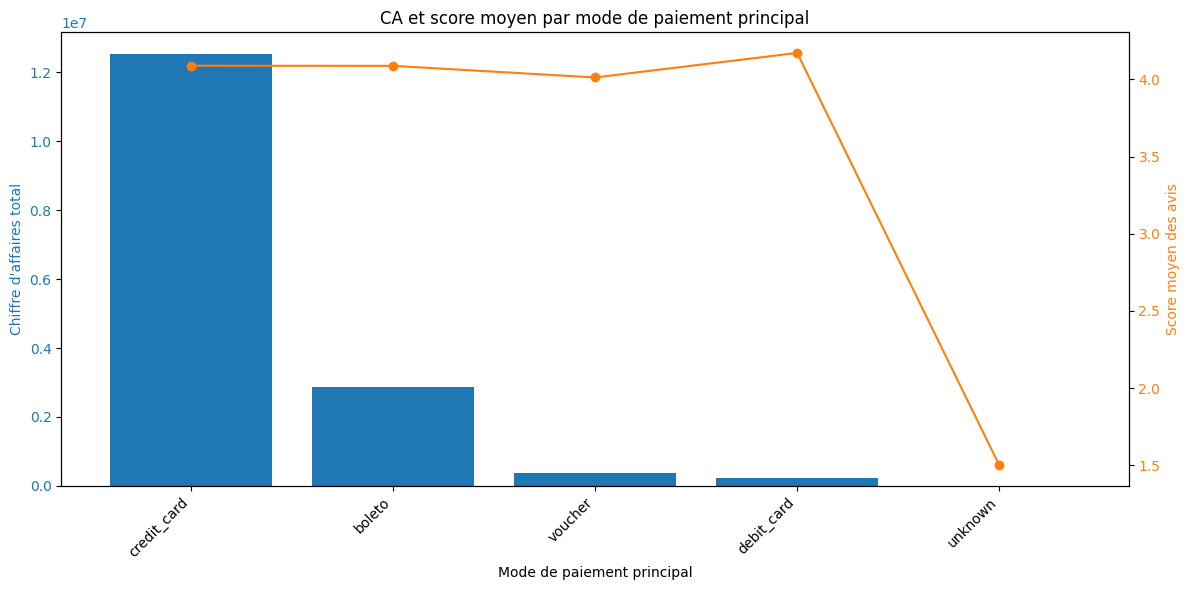

In [90]:
# 6) CA et score moyen par mode de paiement principal (graphe combiné)

# Détermination du mode de paiement principal
pay_value_cols = [c for c in fva.columns if c.startswith("value_") and c != "value"]

def main_payment_type(row):
    sub = row[pay_value_cols]
    if sub.isna().all() or sub.max() == 0:
        return "unknown"
    return sub.idxmax().replace("value_", "")

fva["main_payment_type"] = fva[pay_value_cols].apply(main_payment_type, axis=1)

# Agrégation
pay_agg = (
    fva
    .groupby("main_payment_type", as_index=False)
    .agg(
        orders_count=("order_id", "nunique"),
        revenue=("value", "sum"),
        avg_score=("score", "mean"),
    )
    .sort_values("revenue", ascending=False)
)

print("== 6) Synthèse par mode de paiement principal ==")
print(pay_agg)

# Graphe unique
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(pay_agg["main_payment_type"], pay_agg["revenue"])
ax1.set_xlabel("Mode de paiement principal")
ax1.set_ylabel("Chiffre d'affaires total", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")
plt.xticks(rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(pay_agg["main_payment_type"], pay_agg["avg_score"],
         marker="o", linestyle="-", color="C1")
ax2.set_ylabel("Score moyen des avis", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")

plt.title("CA et score moyen par mode de paiement principal")
plt.tight_layout()
plt.show()


In [ ]:
# La carte de crédit concentre presque tout le chiffre d’affaires, ce qui reflète bien
# les habitudes d’achat au Brésil. Le boleto arrive loin derrière, mais avec un score
# moyen très proche : le mode de paiement n’a donc pas d’impact notable sur la
# satisfaction. Les autres moyens (voucher, débit) restent marginaux mais conservent
# des notes élevées. Le cas “unknown” n’est pas exploitable car il concerne seulement
# quatre commandes. Au global, le choix du paiement explique surtout la répartition du
# CA, tandis que les avis clients restent stables quel que soit le moyen utilisé.


== 7) Top 10 états clients par CA ==
           name_state  orders_count     revenue  avg_score
25          São Paulo         41746  5998226.96   4.173913
20     Rio de Janeiro         12852  2144379.69   3.878404
12       Minas Gerais         11635  1872257.26   4.134813
19  Rio Grande do Sul          5466   890898.54   4.134036
13             Paraná          5045   811156.38   4.181491
23     Santa Catarina          3637   623086.43   4.074167
4               Bahia          3380   616645.82   3.861094
6    District fédéral          2140   355141.08   4.071462
8               Goiás          2020   350092.31   4.045181
7      Espírito Santo          2033   325967.55   4.035553


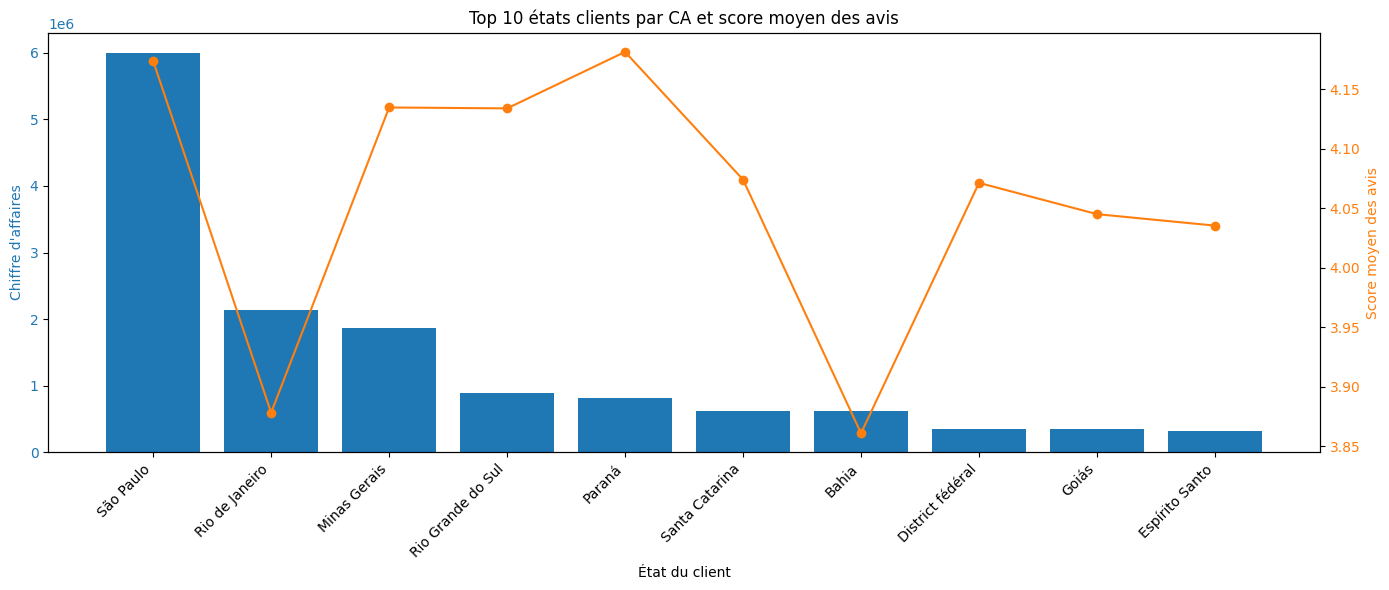

In [53]:
# 7) CA et score moyen par ÉTAT client (Top 10)

# Prépa + agrégation
state_top10 = (
    fva
    .merge(customers[["customer_id", "name_state"]], on="customer_id", how="left")
    .groupby("name_state", as_index=False)
    .agg(
        orders_count=("order_id", "nunique"),
        revenue=("value", "sum"),
        avg_score=("score", "mean"),
    )
    .sort_values("revenue", ascending=False)
    .head(10)
)

print("== 7) Top 10 états clients par CA ==")
print(state_top10[["name_state", "orders_count", "revenue", "avg_score"]])

# Graphe unique : CA (barres) + score moyen (courbe)
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.bar(state_top10["name_state"], state_top10["revenue"])
ax1.set_xlabel("État du client")
ax1.set_ylabel("Chiffre d'affaires", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")
plt.xticks(rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(state_top10["name_state"], state_top10["avg_score"],
         marker="o", linestyle="-", color="C1")
ax2.set_ylabel("Score moyen des avis", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")

plt.title("Top 10 états clients par CA et score moyen des avis")
plt.tight_layout()
plt.show()

== 8) Synthèse par jour de la semaine ==
   weekday  orders_count     revenue  avg_score weekday_name
0        0         16196  2622457.97   4.101797        Lundi
1        1         15963  2560743.03   4.096985        Mardi
2        2         15552  2493114.66   4.111647     Mercredi
3        3         14761  2384544.22   4.087204        Jeudi
4        4         14122  2307128.20   4.033324     Vendredi
5        5         10887  1768427.68   4.070636       Samedi
6        6         11960  1872456.36   4.097396     Dimanche


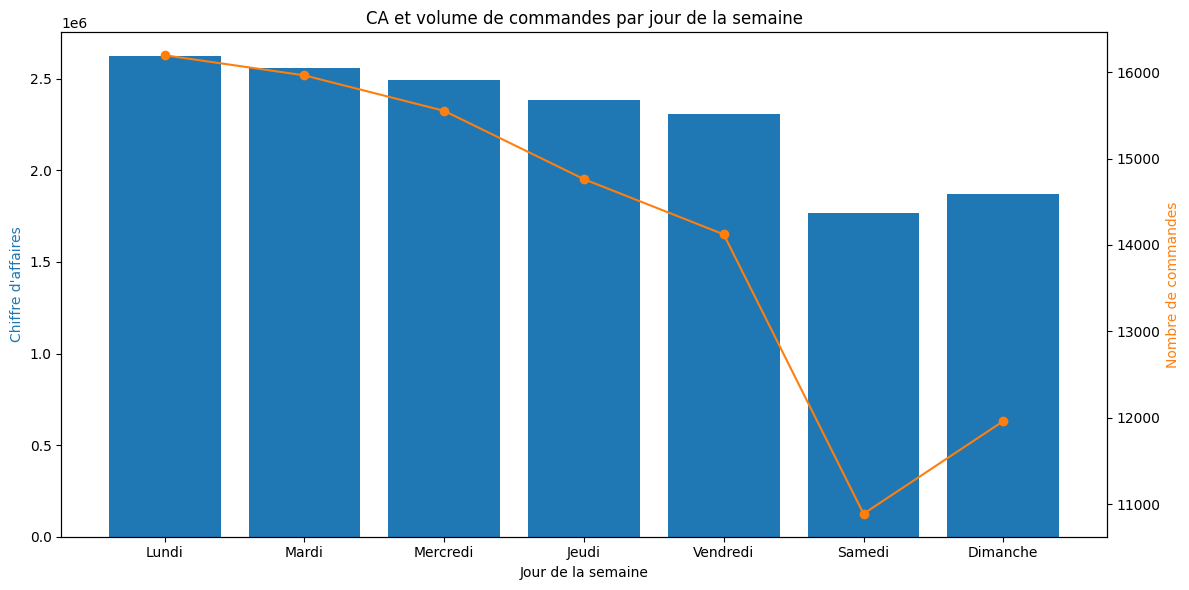

In [54]:
# 8) CA et volume de commandes par jour de la semaine

# 0 = lundi, 6 = dimanche
fva["weekday"] = fva["purchase_timestamp"].dt.dayofweek
weekday_labels = {
    0: "Lundi",
    1: "Mardi",
    2: "Mercredi",
    3: "Jeudi",
    4: "Vendredi",
    5: "Samedi",
    6: "Dimanche"
}
fva["weekday_name"] = fva["weekday"].map(weekday_labels)

weekly = (
    fva
    .groupby("weekday", as_index=False)
    .agg(
        orders_count=("order_id", "nunique"),
        revenue=("value", "sum"),
        avg_score=("score", "mean")
    )
)

weekly["weekday_name"] = weekly["weekday"].map(weekday_labels)

print("== 8) Synthèse par jour de la semaine ==")
print(weekly)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(weekly["weekday_name"], weekly["revenue"])
ax1.set_xlabel("Jour de la semaine")
ax1.set_ylabel("Chiffre d'affaires", color="C0")

ax2 = ax1.twinx()
ax2.plot(weekly["weekday_name"], weekly["orders_count"], marker="o", color="C1")
ax2.set_ylabel("Nombre de commandes", color="C1")

plt.title("CA et volume de commandes par jour de la semaine")
plt.tight_layout()
plt.show()


== 9) Valeur moyenne et volume par score d'avis ==
   score  orders_count   avg_value  total_revenue
0    1.0         11286  195.950001     2211295.76
1    2.0          3139  172.611825      541828.52
2    3.0          8085  151.801749     1227317.14
3    4.0         18964  155.001420     2939446.92
4    5.0         56739  156.512949     8880388.22


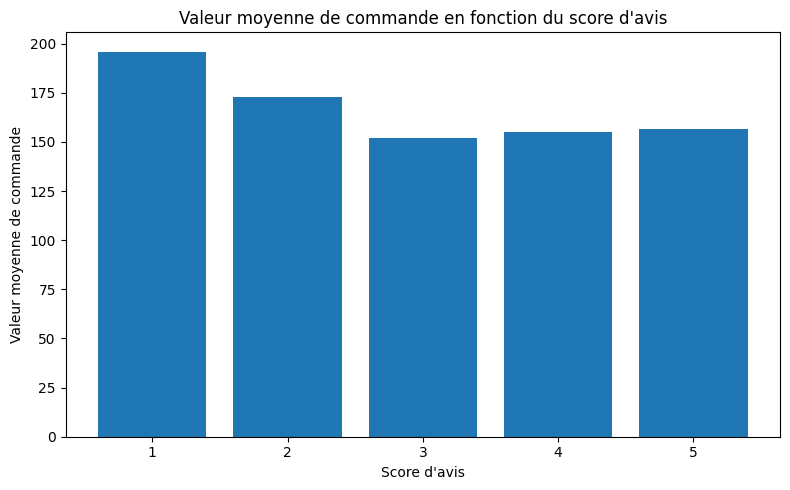

In [55]:
# 9) Valeur moyenne de commande en fonction du score d'avis

score_value = (
    fva
    .groupby("score", as_index=False)
    .agg(
        orders_count=("order_id", "nunique"),
        avg_value=("value", "mean"),
        total_revenue=("value", "sum")
    )
)

print("== 9) Valeur moyenne et volume par score d'avis ==")
print(score_value)

plt.figure(figsize=(8, 5))
plt.bar(score_value["score"], score_value["avg_value"])
plt.xlabel("Score d'avis")
plt.ylabel("Valeur moyenne de commande")
plt.title("Valeur moyenne de commande en fonction du score d'avis")
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()
